In [1]:
import anndata as ad
import squidpy as sq
import cellcharter as cc
import pandas as pd
import scanpy as sc
import scvi
import numpy as np
import matplotlib.pyplot as plt
from lightning.pytorch import seed_everything

seed_everything(12345)
scvi.settings.seed = 12345

/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text ins

In [2]:
! mkdir tutorial_data
! mkdir tutorial_data/nanostring_data
! wget -P tutorial_data/nanostring_data https://nanostring-public-share.s3.us-west-2.amazonaws.com/SMI-Compressed/Lung9_Rep1/Lung9_Rep1+SMI+Flat+data.tar.gz
! wget -P tutorial_data/nanostring_data https://nanostring-public-share.s3.us-west-2.amazonaws.com/SMI-Compressed/Lung9_Rep2/Lung9_Rep2+SMI+Flat+data.tar.gz
! tar -xzf tutorial_data/nanostring_data/Lung9_Rep1+SMI+Flat+data.tar.gz -C tutorial_data/nanostring_data/.
! tar -xzf tutorial_data/nanostring_data/Lung9_Rep2+SMI+Flat+data.tar.gz -C tutorial_data/nanostring_data/.

--2026-02-16 11:30:44--  https://nanostring-public-share.s3.us-west-2.amazonaws.com/SMI-Compressed/Lung9_Rep1/Lung9_Rep1+SMI+Flat+data.tar.gz
Resolving nanostring-public-share.s3.us-west-2.amazonaws.com (nanostring-public-share.s3.us-west-2.amazonaws.com)... 52.92.248.10, 3.5.83.194, 3.5.81.32, ...
Connecting to nanostring-public-share.s3.us-west-2.amazonaws.com (nanostring-public-share.s3.us-west-2.amazonaws.com)|52.92.248.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1078783664 (1.0G) [binary/octet-stream]
Saving to: ‘tutorial_data/nanostring_data/Lung9_Rep1+SMI+Flat+data.tar.gz’

Lung9_Rep1+SMI+Flat 100%[===================>]   1.00G  4.63MB/s    in 3m 15s  

2026-02-16 11:34:01 (5.28 MB/s) - ‘tutorial_data/nanostring_data/Lung9_Rep1+SMI+Flat+data.tar.gz’ saved [1078783664/1078783664]

--2026-02-16 11:34:01--  https://nanostring-public-share.s3.us-west-2.amazonaws.com/SMI-Compressed/Lung9_Rep2/Lung9_Rep2+SMI+Flat+data.tar.gz
Resolving nanostring-public

In [3]:
adata_list = []
for sample in ['Lung9_Rep1', 'Lung9_Rep2']:
    adata = sq.read.nanostring(
        path=f'tutorial_data/nanostring_data/{sample}/{sample}-Flat_files_and_images', 
        counts_file=f'{sample}_exprMat_file.csv',
        meta_file=f'{sample}_metadata_file.csv',
        fov_file=f'{sample}_fov_positions_file.csv'
    )

    # Flip y axis
    adata.obsm['spatial_fov'][:, 1] = np.max(adata.obsm['spatial_fov'][:, 1]) - adata.obsm['spatial_fov'][:, 1]

    # Remove negative probes
    adata = adata[:, [c for c in adata.var_names if 'NegPrb' not in c]].copy()
    
    adata.obs['sample'] = sample
    adata_list.append(adata)

In [4]:
adata = ad.concat(adata_list, axis=0, merge='same', pairwise=True, index_unique='_')

# 'spatial_fov' refers to global coordinates of the cells.
# Thus, we are going to use 'spatial_fov' and not 'spatial' as spatial coordinates.
adata.uns['spatial_fov'] = {s: {} for s in adata.obs['sample'].unique()}
adata.obs['sample'] = pd.Categorical(adata.obs['sample'])
adata

AnnData object with n_obs × n_vars = 242476 × 960
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'sample'
    uns: 'spatial_fov'
    obsm: 'spatial', 'spatial_fov'

In [5]:
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

In [6]:
adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [7]:
scvi.model.SCVI.setup_anndata(
    adata, 
    layer="counts", 
    batch_key='sample',
)

model = scvi.model.SCVI(adata)

In [8]:
model.train(early_stopping=True, enable_progress_bar=True)


/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Epoch 33/33: 100%|██████████| 33/33 [13:13<00:00, 21.42s/it, v_num=1, train_loss_step=348, train_loss_epoch=343]

`Trainer.fit` stopped: `max_epochs=33` reached.


Epoch 33/33: 100%|██████████| 33/33 [13:13<00:00, 24.03s/it, v_num=1, train_loss_step=348, train_loss_epoch=343]


In [9]:
adata.obsm['X_scVI'] = model.get_latent_representation(adata).astype(np.float32)


In [15]:
adata.write('data/cosmx.h5ad')

In [13]:
sq.gr.spatial_neighbors(adata, library_key='sample', coord_type='generic', delaunay=True, spatial_key='spatial_fov', percentile=99)


In [14]:
cc.gr.aggregate_neighbors(adata, n_layers=3, use_rep='X_scVI', out_key='X_cellcharter', sample_key='sample')


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


In [16]:
gmm = cc.tl.Cluster(
    n_clusters=11, 
    random_state=12345,
    # If running on GPU
    #trainer_params=dict(accelerator='gpu', devices=1)
)

In [ ]:
gmm.fit(adata, use_rep='X_cellcharter')
adata.obs['spatial_cluster'] = gmm.predict(adata, use_rep='X_cellcharter')

In [10]:
# GMM components to try
# GMM components to try
gmm_components = [15,20]



In [11]:
from sklearn.mixture import GaussianMixture
import pandas as pd

X = adata.obsm['X_cellcharter']
gmm_results = []

for k in gmm_components:
    print(k)
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='full',
        random_state=0,
        n_init=3,
    )
    labels = gmm.fit_predict(X)
    key = f'CellCharter_{k}'
    adata.obs[key] = labels.astype(str)
    gmm_results.append({
        'k': k,
        'bic': gmm.bic(X),
        'aic': gmm.aic(X),
    })
    n_clusters = adata.obs[key].nunique()
    print(f'k={k}: {n_clusters} clusters')


15


/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3

k=15: 15 clusters
20


/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3

k=20: 20 clusters


In [12]:
adata.obs

fov  Area  AspectRatio  CenterX_global_px  CenterY_global_px  Width  \
2_1_0       1  4191         2.20        1913.333333      140378.555556    112   
3_1_0       1  4566         0.97        2157.333333      140364.555556     76   
4_1_0       1  4288         1.48        2350.333333      140372.555556     92   
5_1_0       1  1118         1.52        2483.333333      140387.555556     50   
6_1_0       1  1708         1.33        2526.333333      140382.555556     56   
...        ..   ...          ...                ...                ...    ...   
3040_45_1  45  1854         2.39        4274.888889         339.222222     74   
3041_45_1  45   775         1.87        4325.888889         335.222222     43   
3042_45_1  45  1629         3.42        3206.888889         335.222222     82   
3043_45_1  45   545         3.40        6480.888889         331.222222     51   
3044_45_1  45   642         4.14        7800.888889         330.222222     58   

           Height  Mean.MembraneStain  Max.MembraneStain  Mean.PanCK  ...  \
2_1_0          51                7377              16475        4133  ...   
3_1_0          78                9058              13283         700  ...   
4_1_0          62                8677              12168         702  ...   
5_1_0          33                9498              12022         678  ...   
6_1_0          42               10476              14461        3239  ...   
...           ...                 ...                ...         ...  ...   
3040_45_1      31               14434              31918         611  ...   
3041_45_1      23               17157              31514         555  ...   
3042_45_1      24               33971              63567       18165  ...   
3043_45_1      15               29605              41251        8258  ...   
3044_45_1      14               24018              44247        4194  ...   

               sample  n_counts  _scvi_batch  _scvi_labels  CellCharter_10  \
2_1_0      Lung9_Rep1        56            0             0               4   
3_1_0      Lung9_Rep1        47            0             0               8   
4_1_0      Lung9_Rep1        33            0             0               7   
5_1_0      Lung9_Rep1         9            0             0               7   
6_1_0      Lung9_Rep1        30            0             0               7   
...               ...       ...          ...           ...             ...   
3040_45_1  Lung9_Rep2         3            1             0               7   
3041_45_1  Lung9_Rep2         4            1             0               3   
3042_45_1  Lung9_Rep2         4            1             0               4   
3043_45_1  Lung9_Rep2         3            1             0               4   
3044_45_1  Lung9_Rep2         5            1             0               4   

            sample_id  spatial_fov  library_id CellCharter_15  CellCharter_20  
2_1_0      Lung9_Rep1          NaN  Lung9_Rep1              8               1  
3_1_0      Lung9_Rep1          NaN  Lung9_Rep1              8               4  
4_1_0      Lung9_Rep1          NaN  Lung9_Rep1              8               4  
5_1_0      Lung9_Rep1          NaN  Lung9_Rep1              8               4  
6_1_0      Lung9_Rep1          NaN  Lung9_Rep1              8               4  
...               ...          ...         ...            ...             ...  
3040_45_1  Lung9_Rep2          NaN  Lung9_Rep2              8              11  
3041_45_1  Lung9_Rep2          NaN  Lung9_Rep2              7              13  
3042_45_1  Lung9_Rep2          NaN  Lung9_Rep2              8               4  
3043_45_1  Lung9_Rep2          NaN  Lung9_Rep2              2               1  
3044_45_1  Lung9_Rep2          NaN  Lung9_Rep2              2               1  

[241008 rows x 28 columns]

In [33]:
adata.uns['spatial_fov']

{'Lung9_Rep1': {}, 'Lung9_Rep2': {}}

In [29]:
adata.obs['sample_id'] = 'CoxMx'

In [14]:
import sys
sys.path.append("/Users/christoffer/work/karolinska/development/MANA")
from utils import aggregate_neighbors_weighted, plot_spatial_compact_fast

In [ ]:
adata.uns['spatial_fov']

{'Lung9_Rep1': {}, 'Lung9_Rep2': {}}

In [38]:
# `sample` already contains the per-cell library IDs used by squidpy
adata.obs["sample_id"] = adata.obs["sample"].astype("category")

# check
adata.obs["sample_id"].value_counts()


sample_id
Lung9_Rep2    149445
Lung9_Rep1     91563
Name: count, dtype: int64

In [54]:
adata.obs["sample_id"] = adata.obs["sample"].astype("category")
adata.obsm["spatial"] = adata.obsm["spatial_fov"].copy()


/Users/christoffer/work/karolinska/development/MANA/utils/plot_spatial_compact_fast.py:121: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col_series):
/Users/christoffer/work/karolinska/development/MANA/utils/plot_spatial_compact_fast.py:206: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col_series):
/Users/christoffer/work/karolinska/development/MANA/utils/plot_spatial_compact_fast.py:280: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(gser) and gser.cat.ordered:


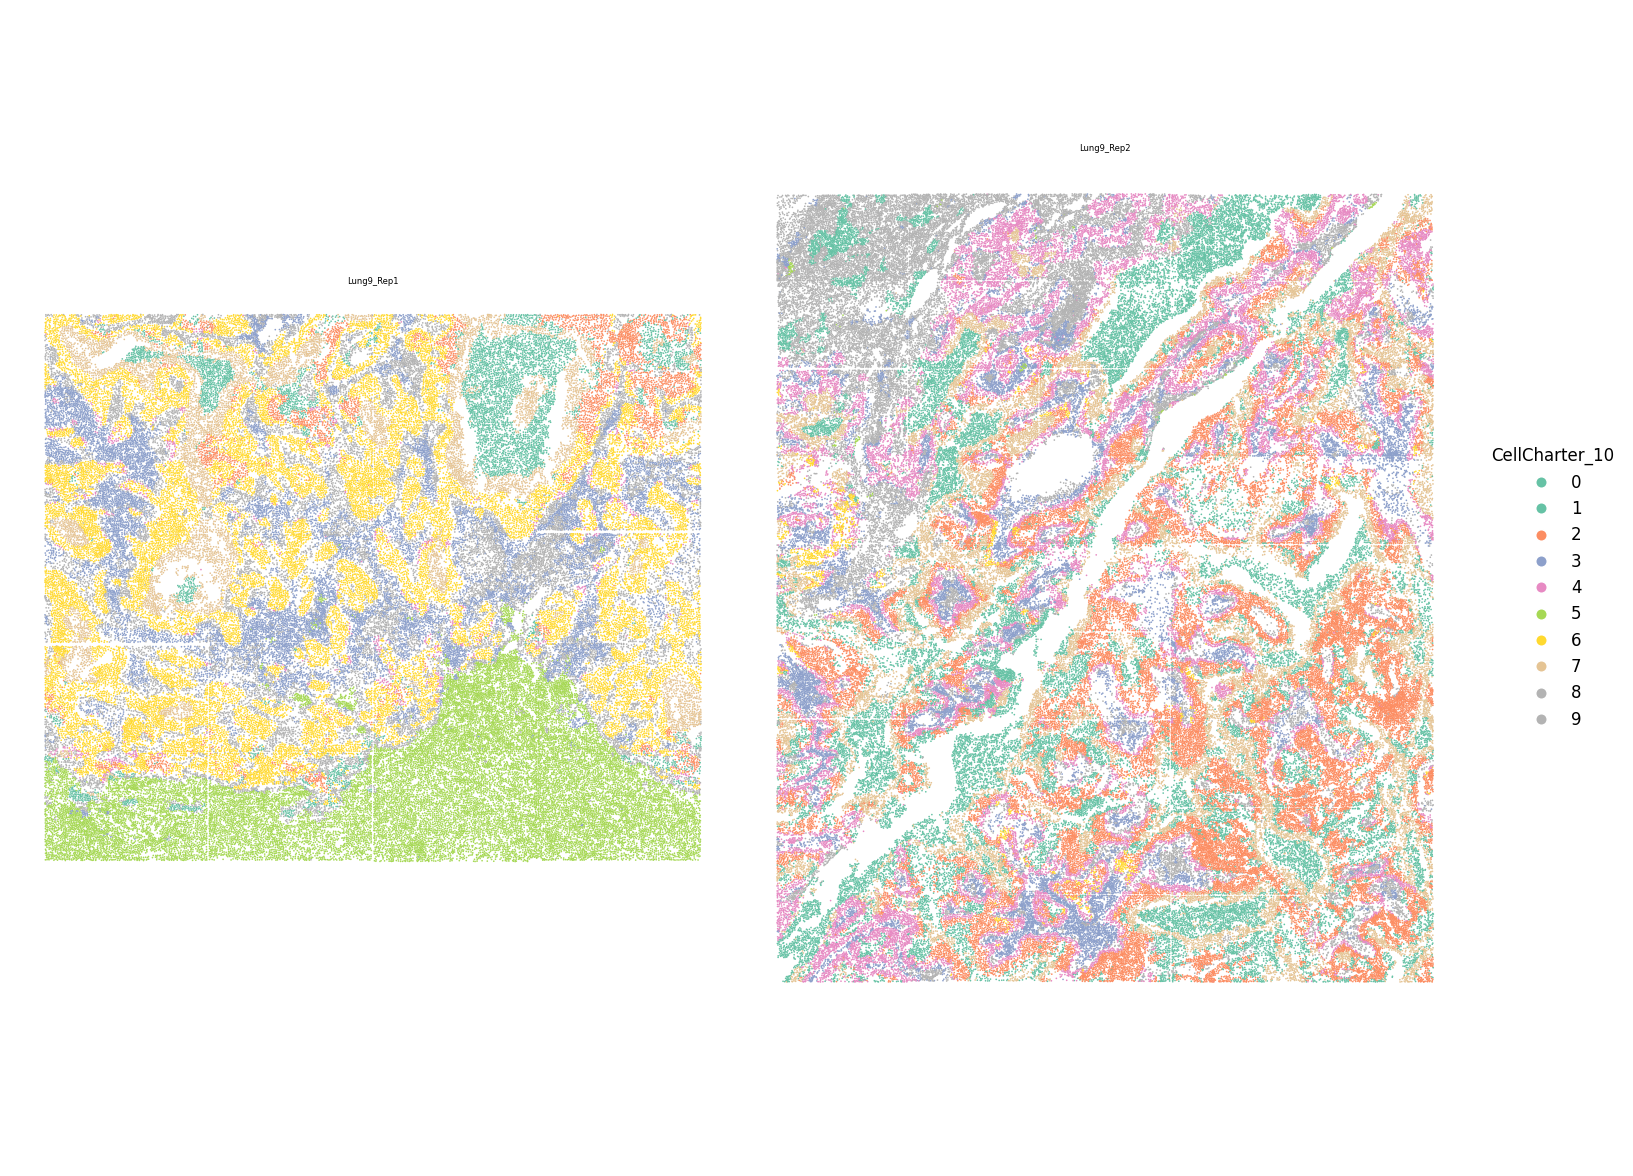

In [ ]:
plot_spatial_compact_fast(
    adata,
    color="CellCharter_10",
    groupby="library_id",
    spot_size=1,
    cols=2,
    height=10,
    background="white",
    dpi=120,
)


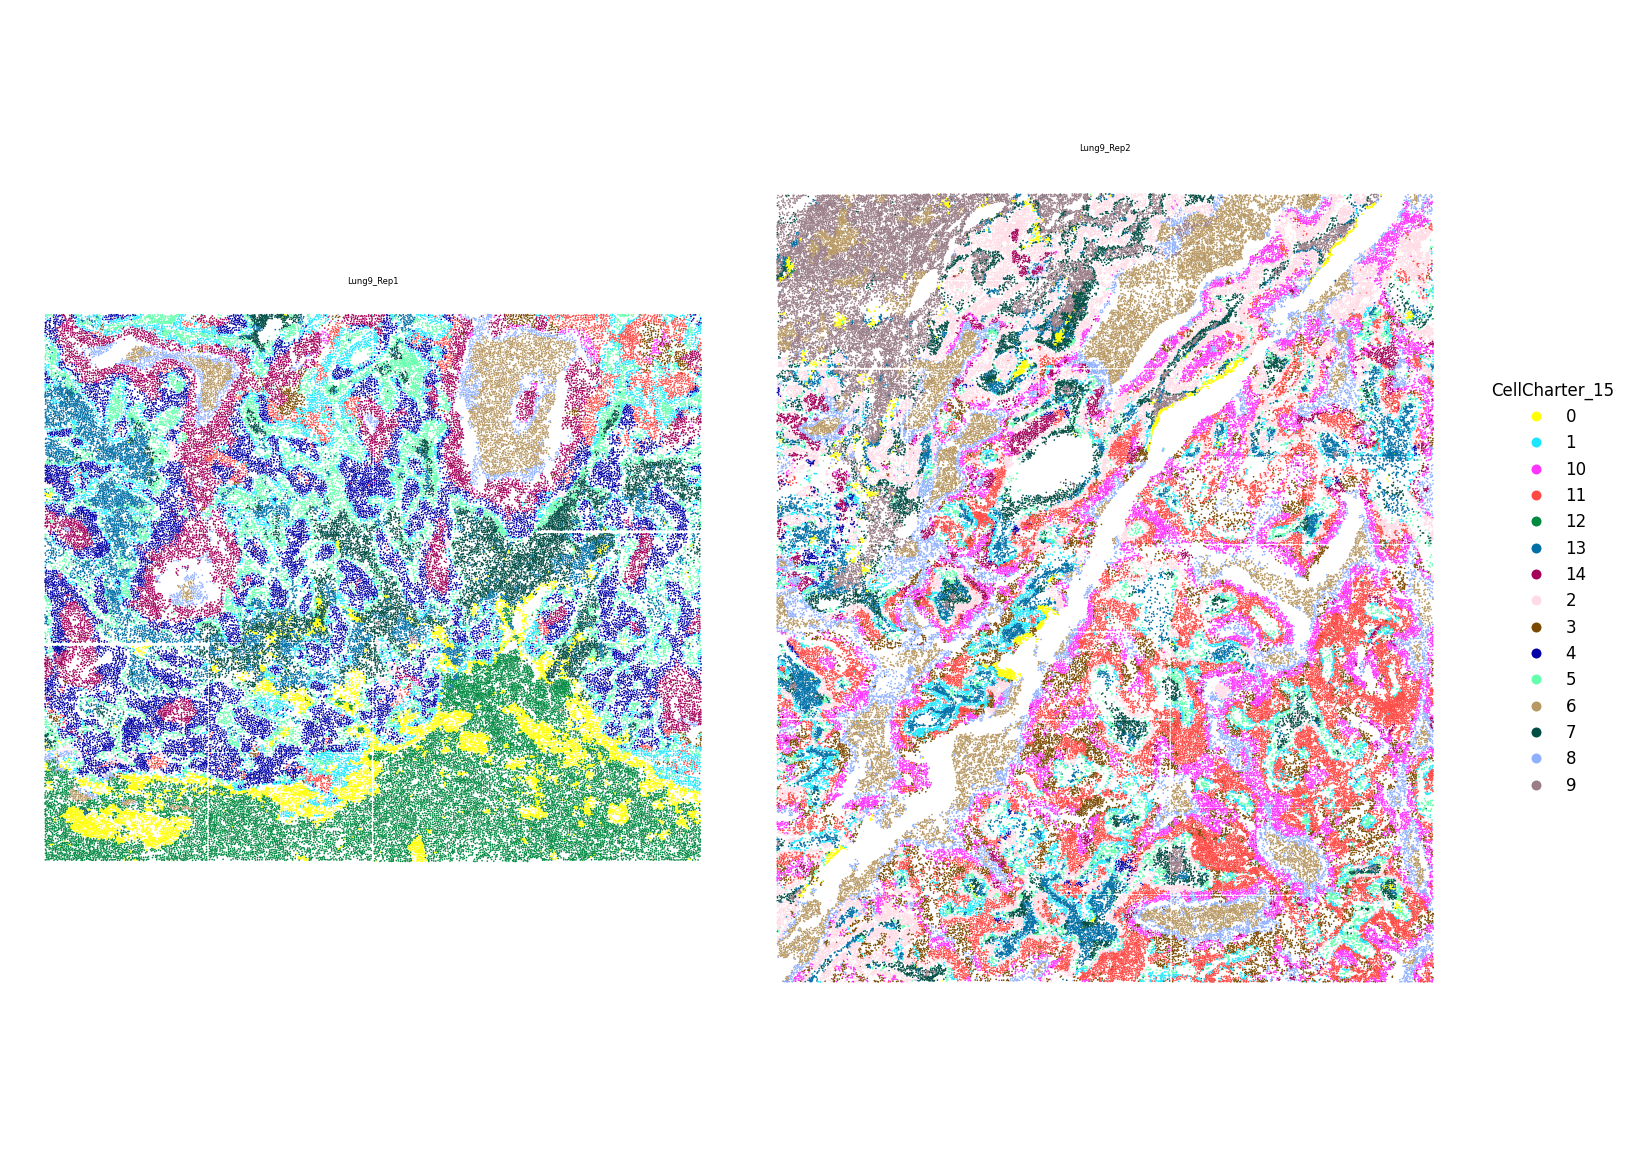

In [ ]:
plot_spatial_compact_fast(
    adata,
    color="CellCharter_15",
    groupby="library_id",
    spot_size=1,
    cols=2,
    height=10,
    background="white",
    dpi=120,
)


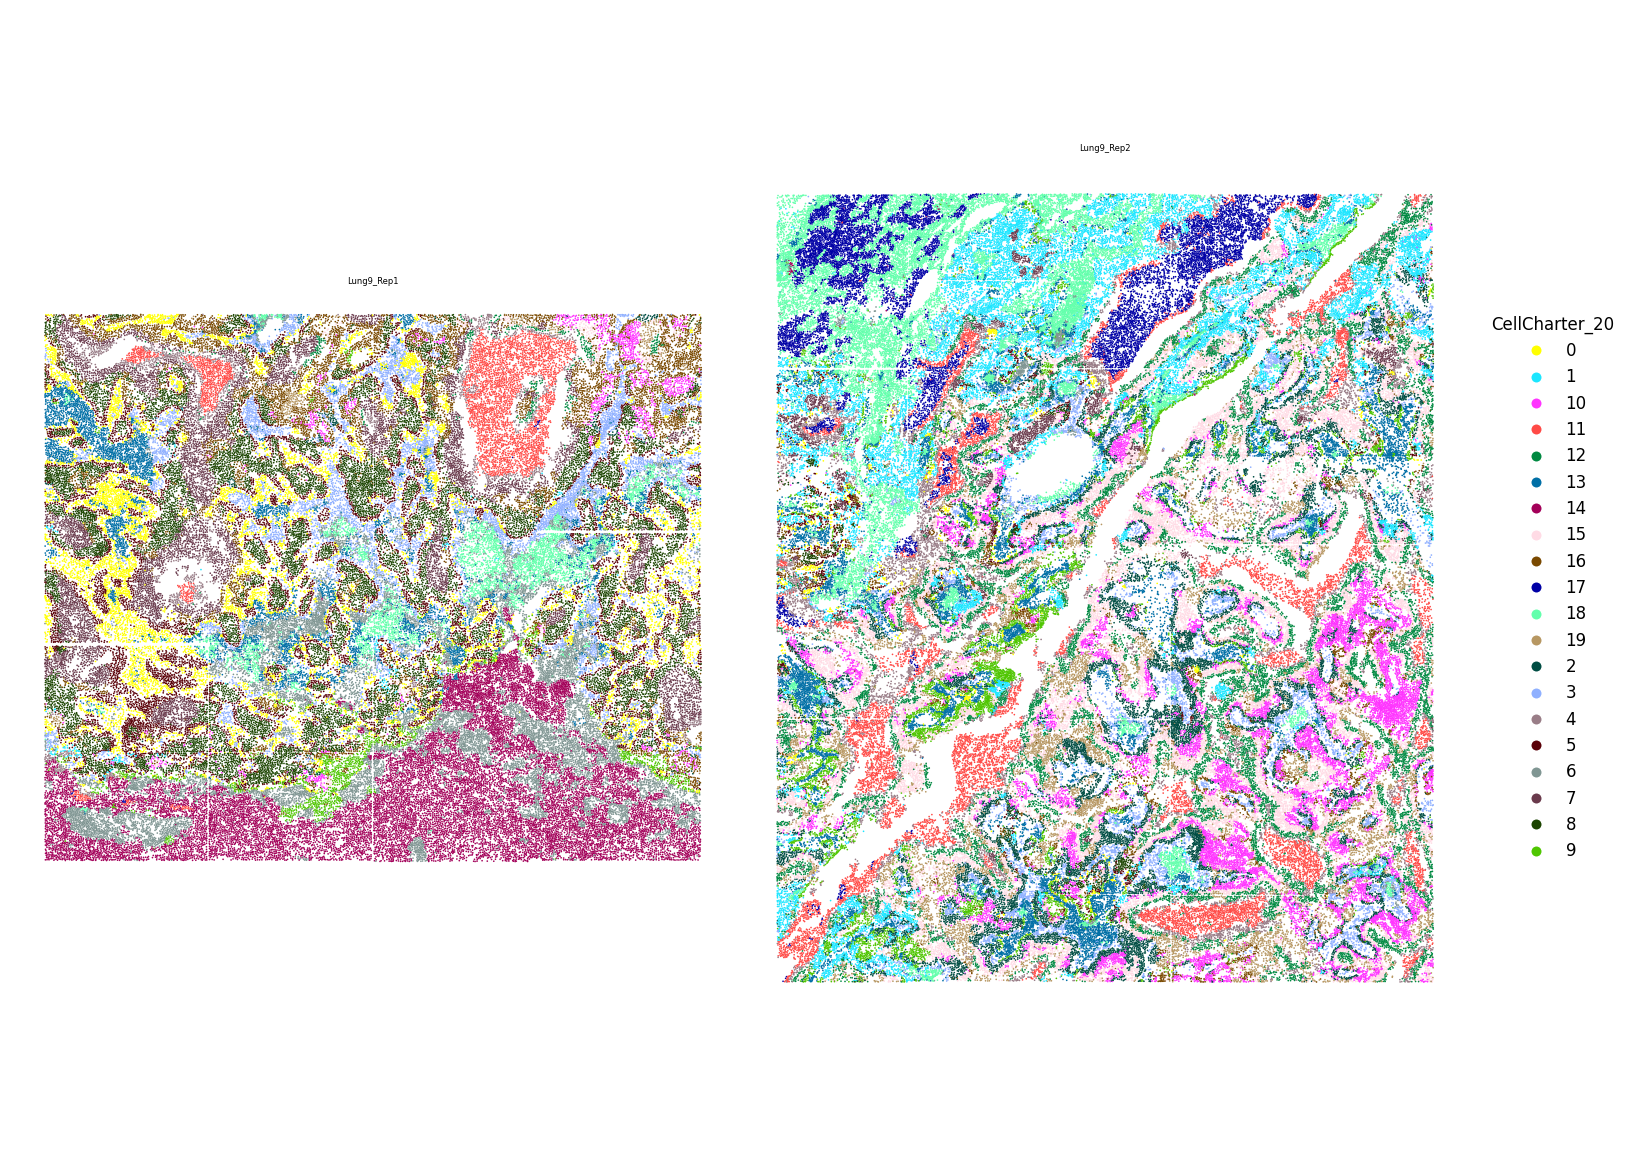

In [16]:
plot_spatial_compact_fast(
    adata,
    color="CellCharter_20",
    groupby="library_id",
    spot_size=1,
    cols=2,
    height=10,
    background="white",
    dpi=120,
)


In [20]:
adata

AnnData object with n_obs × n_vars = 241008 × 960
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'sample', 'n_counts', '_scvi_batch', '_scvi_labels', 'CellCharter_10', 'sample_id', 'spatial_fov', 'library_id', 'CellCharter_15', 'CellCharter_20'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'CellCharter_10_colors', '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'spatial_fov', 'spatial_neighbors', 'hvg', 'CellCharter_15_colors', 'CellCharter_20_colors'
    obsm: 'X_cellcharter', 'X_scVI', 'spatial', 'spatial_fov'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [22]:
adata.write('/Volumes/processing2/KaroSpaceDataWrangle/coxms2.h5ad')

In [1]:
import scanpy as sc

/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [3]:
adata = sc.read_h5ad('/Volumes/processing2/KaroSpaceDataWrangle/h5ad/coxms.h5ad')

In [5]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat",                # robust on log-normalized X
    n_top_genes=min(adata.n_vars, 100),
    batch_key="sample",
)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
min(adata.n_vars, 20)

20

In [9]:
adata.obs

fov  Area  AspectRatio  CenterX_global_px  CenterY_global_px  Width  \
2_1_0       1  4191         2.20        1913.333333      140378.555556    112   
3_1_0       1  4566         0.97        2157.333333      140364.555556     76   
4_1_0       1  4288         1.48        2350.333333      140372.555556     92   
5_1_0       1  1118         1.52        2483.333333      140387.555556     50   
6_1_0       1  1708         1.33        2526.333333      140382.555556     56   
...        ..   ...          ...                ...                ...    ...   
3040_45_1  45  1854         2.39        4274.888889         339.222222     74   
3041_45_1  45   775         1.87        4325.888889         335.222222     43   
3042_45_1  45  1629         3.42        3206.888889         335.222222     82   
3043_45_1  45   545         3.40        6480.888889         331.222222     51   
3044_45_1  45   642         4.14        7800.888889         330.222222     58   

           Height  Mean.MembraneStain  Max.MembraneStain  Mean.PanCK  ...  \
2_1_0          51                7377              16475        4133  ...   
3_1_0          78                9058              13283         700  ...   
4_1_0          62                8677              12168         702  ...   
5_1_0          33                9498              12022         678  ...   
6_1_0          42               10476              14461        3239  ...   
...           ...                 ...                ...         ...  ...   
3040_45_1      31               14434              31918         611  ...   
3041_45_1      23               17157              31514         555  ...   
3042_45_1      24               33971              63567       18165  ...   
3043_45_1      15               29605              41251        8258  ...   
3044_45_1      14               24018              44247        4194  ...   

           Max.DAPI  cell_ID      sample  n_counts  _scvi_batch  _scvi_labels  \
2_1_0           942        2  Lung9_Rep1        56            0             0   
3_1_0          1814        3  Lung9_Rep1        47            0             0   
4_1_0          1467        4  Lung9_Rep1        33            0             0   
5_1_0          1005        5  Lung9_Rep1         9            0             0   
6_1_0          2044        6  Lung9_Rep1        30            0             0   
...             ...      ...         ...       ...          ...           ...   
3040_45_1      1905     3040  Lung9_Rep2         3            1             0   
3041_45_1      2701     3041  Lung9_Rep2         4            1             0   
3042_45_1      1859     3042  Lung9_Rep2         4            1             0   
3043_45_1      1091     3043  Lung9_Rep2         3            1             0   
3044_45_1       816     3044  Lung9_Rep2         5            1             0   

           CellCharter_10   sample_id spatial_fov  library_id  
2_1_0                   4  Lung9_Rep1         NaN  Lung9_Rep1  
3_1_0                   8  Lung9_Rep1         NaN  Lung9_Rep1  
4_1_0                   7  Lung9_Rep1         NaN  Lung9_Rep1  
5_1_0                   7  Lung9_Rep1         NaN  Lung9_Rep1  
6_1_0                   7  Lung9_Rep1         NaN  Lung9_Rep1  
...                   ...         ...         ...         ...  
3040_45_1               7  Lung9_Rep2         NaN  Lung9_Rep2  
3041_45_1               3  Lung9_Rep2         NaN  Lung9_Rep2  
3042_45_1               4  Lung9_Rep2         NaN  Lung9_Rep2  
3043_45_1               4  Lung9_Rep2         NaN  Lung9_Rep2  
3044_45_1               4  Lung9_Rep2         NaN  Lung9_Rep2  

[241008 rows x 26 columns]